In [1]:
import copy
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

In [2]:
# Household heterogeneous block
def consumption(c, we, rest, gamma, nu, phi, tauc, taun):
    return (1 + tauc) * c - (1 - taun) * we * ((1 - taun) * we / ((1 + tauc) * phi * c ** gamma)) ** (1/nu) - rest

def household_guess(a_grid, e_grid, r, w, gamma, T, tauc, taun):
    wel = (1 + r) * a_grid[np.newaxis,:] + (1 - taun) * w * e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1 + r) / (1 + tauc) * (wel * 0.1) ** (-gamma) # check
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p, a_grid, e_grid, r, w, T, beta, gamma, nu, phi, tauc, taun):

    we = w * e_grid
    c_prime = (beta * (1 + tauc) * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t
    n_prime = ((1 - taun) * we[:,np.newaxis] / ((1 + tauc) * phi * c_prime ** gamma)) ** (1/nu)
    new_grid = ((1 + tauc) * c_prime + a_grid[np.newaxis,:] - (1 - taun) * we[:,np.newaxis] * n_prime 
                - T[:,np.newaxis])
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + (1 - taun) * we[:,np.newaxis] * n + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) / (1 + tauc) * c ** (-gamma) # check

    # Check for violation of the asset constraint and fix it
    indexes_asset = np.nonzero(a < a_grid[0]) # first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        aa = np.zeros((indexes_asset[0].size)) + 1E-10 # was 1E-5
        rest = wel[indexes_asset[1]] - a_grid[0] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5 + 100
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],
                                                                 rest,gamma,nu,phi,tauc,taun),aa,bb)
        n[indexes_asset] = ((1 - taun) * we[indexes_asset[0]] 
                            / ((1 + tauc) * phi * c[indexes_asset] ** gamma)) ** (1/nu)
        V_prime[indexes_asset] = (1 + r) / (1 + tauc) * (c[indexes_asset]) ** (-gamma) # check
    return V_prime, a, c, n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho = rho_e, sigma = sd_e, N = nE)
    a_grid = grids.agrid(amin = amin, amax = amax, n = nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

household_inp = household.add_hetinputs([make_grid,transfers])

print(household_inp)
print(f'Inputs: {household_inp.inputs}')

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'T', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']
<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'w', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['r', 'w', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [3]:
# The rest of the code is identical to the one-asset HANK example in their notebook
@simple
def firm(Y, w, Z, pi, mu, kappa, tauc):
    L = Y / Z
    Div = Y - w * L - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    cpi = (1 + pi) * (1 + tauc) - 1
    return L, Div, cpi

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    i = rstar
    return r, i

@simple
def fiscal(r, Transfer, B, C, L, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * L - B
    Deficit = tauc * C + taun * w * L - Transfer # primary surplus
    Trans = Transfer
    return govt_res, Deficit, Trans

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

blocks_ss = [hh_ext, firm, monetary,fiscal, nkpc_ss, mkt_clearing]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']
Outputs: ['A', 'C', 'N', 'NE', 'L', 'Div', 'cpi', 'r', 'i', 'govt_res', 'Deficit', 'Trans', 'w', 'asset_mkt', 'labor_mkt', 'goods_mkt']


In [4]:
calibration = {'gamma': 1.0, 'nu': 2.0, 'rho_e': 0.966, 'sd_e': 0.92, 'nE': 8,
               'amin': 0, 'amax': 200, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0, 
               'tauc': 0.1, 'taun': 0.036}

unknowns_ss = {'beta': 0.986, 'phi': 0.8, 'Transfer': 0.05}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

#plt.plot(ss0.internals['household']['a_grid'], ss0.internals['household']['n'].T)
#plt.xlabel('Assets'), plt.ylabel('Labor supply')
#plt.show()

In [5]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name = "One-Asset HANK")
#print(*hank.blocks, sep='\n')
ss = hank.steady_state(ss0)

#for k in ss0.keys():
#    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
exogenous = ['rstar', 'Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
#print(G)

In [6]:
# Steady state properties

# Fraction of hand-to-mouth households
zero_asset = np.where(ss.internals['household']['a'] == 0)
htm = ss.internals['household']['Dbeg'][zero_asset]
htm1 = ss.internals['household']['D'][zero_asset]
htm = sum(htm)
htm1 = sum(htm1)
print('Share of hand-to-mouth households = ', np.round(htm, 3) * 100,'%')
#print('Share of hand-to-mouth D    ', np.round(htm1, 3) * 100,'%')

# Wealth distribution and Gini coefficient on wealth
asset_pos = np.argsort(ss.internals['household']['a'], axis=None) # sort the flattened array
asset = np.reshape(ss.internals['household']['a'], (np.size(ss.internals['household']['a']),))
mass = np.reshape(ss.internals['household']['Dbeg'], (np.size(ss.internals['household']['a']),))
asset_mass = np.multiply(asset[asset_pos], mass[asset_pos])
total_wealth = np.sum(asset_mass, axis=None)
from numpy import trapz
lorenz_wealth = trapz(np.cumsum(asset_mass / total_wealth), dx=1/np.size(ss.internals['household']['a'])) # area below Lorenz curve
gini_wealth = (0.5 - lorenz_wealth) / 0.5
print("Wealth Gini =", np.round(gini_wealth, 3))

# Consumption distribution
cons_pos = np.argsort(ss.internals['household']['c'], axis=None) # sort the flattened array
cons = np.reshape(ss.internals['household']['c'], (np.size(ss.internals['household']['a']),))
mass = np.reshape(ss.internals['household']['Dbeg'], (np.size(ss.internals['household']['a']),))
cons_mass = np.multiply(asset[cons_pos], mass[cons_pos])
total_cons = np.sum(cons_mass, axis=None)
lorenz_cons = trapz(np.cumsum(cons_mass / total_cons), dx=1/np.size(ss.internals['household']['a'])) # area below Lorenz curve
gini_cons = (0.5 - lorenz_cons) / 0.5
print("Consumption Gini =", np.round(gini_cons, 3))

Share of hand-to-mouth households =  29.799999999999997 %
Wealth Gini = 0.299
Consumption Gini = 0.254


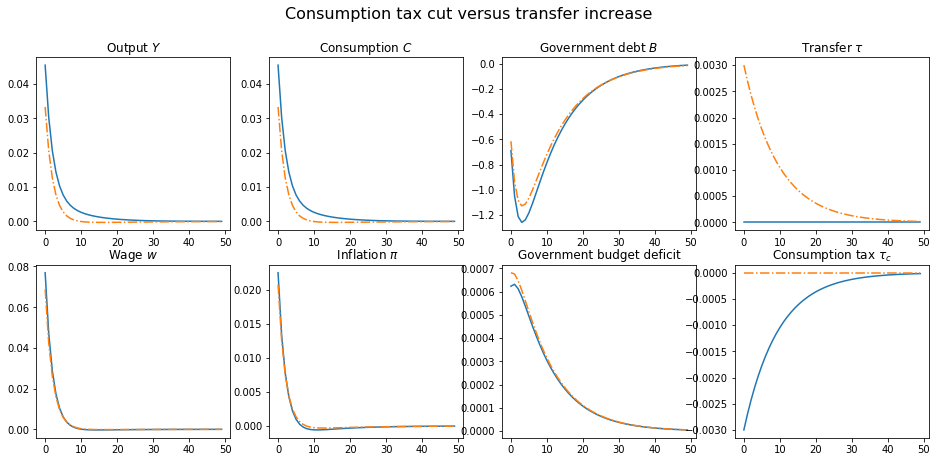

--------------------------------------------------
DIFFERENCE τc vs τ   IMPACT RATIO   CUMULATIVE SUM
--------------------------------------------------
Shocks                  1.000                0.000
Output                  1.365                0.085
Consumption             1.365                0.085
Inflation               1.085               -0.002
Wage                    1.119                0.018
Deficit                 0.915                0.012
-------------------------------------------------------------------------
PARAMETERS
Discount factor                0.977   Intertemporal elasticity     1.000
Labor supply elasticity        0.500   Labor supply disutility      0.782
Goods substitutability         6.000   Price markup                 1.200
Phillips curve slope           0.100   Taylor rule inflation        0.000
Consumption tax rate           0.100   Labor tax rate               0.036

AGGREGATE VARIABLES IN STEADY STATE
Output                         1.000   Government

In [102]:
# Impulse response functions
rhos = 0.9
drstar = -0.02 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.03 * rhos ** (np.arange(T)[:, np.newaxis])
dtauc = - 0.03 * rhos ** (np.arange(T)[:, np.newaxis])

dY = [G['Y']['rstar'] @ drstar, G['Y']['tauc'] @ dtauc, G['Y']['Transfer'] @ dtstar]
dC = [G['C']['rstar'] @ drstar, G['C']['tauc'] @ dtauc, G['C']['Transfer'] @ dtstar]
dN = [G['N']['rstar'] @ drstar, G['N']['tauc'] @ dtauc, G['N']['Transfer'] @ dtstar]
dB = [G['A']['rstar'] @ drstar, G['A']['tauc'] @ dtauc, G['A']['Transfer'] @ dtstar]
dw = [G['w']['rstar'] @ drstar, G['w']['tauc'] @ dtauc, G['w']['Transfer'] @ dtstar]
dP = [G['pi']['rstar'] @ drstar, G['pi']['tauc'] @ dtauc, G['pi']['Transfer'] @ dtstar]
dp = [G['cpi']['rstar'] @ drstar, G['cpi']['tauc'] @ dtauc, G['cpi']['Transfer'] @ dtstar]
dr = [G['r']['rstar'] @ drstar, G['r']['tauc'] @ dtauc, G['r']['Transfer'] @ dtstar]
dD = [G['Deficit']['rstar'] @ drstar, G['Deficit']['tauc'] @ dtauc, G['Deficit']['Transfer'] @ dtstar]
dd = [G['Div']['rstar'] @ drstar, G['Div']['tauc'] @ dtauc, G['Div']['Transfer'] @ dtstar]
dT = [np.zeros(T), np.zeros(T), G['Trans']['Transfer'] @ dtstar]
di = [G['i']['rstar'] @ drstar, np.zeros(T), np.zeros(T)]

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
fig.suptitle('Consumption tax cut versus transfer increase', size=16)

ax[0, 0].set_title(r'Output $Y$')
#l1, = ax[0, 0].plot(dY[0][:50, :])
l1, = ax[0, 0].plot(dY[1][:50, :] * ss['Y'])
l2, = ax[0, 0].plot(dY[2][:50, :] * ss['Y'],'-.')

ax[0, 1].set_title(r'Consumption $C$')
#ax[0, 1].plot(dC[0][:50, :])
ax[0, 1].plot(dC[1][:50, :] * ss['C'])
ax[0, 1].plot(dC[2][:50, :] * ss['C'],'-.')

ax[0, 2].set_title(r'Government debt $B$')
#ax[0, 2].plot(dB[0][:50, :])
ax[0, 2].plot(dB[1][:50, :] * ss['A'])
ax[0, 2].plot(dB[2][:50, :] * ss['A'],'-.')

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dT[2][:50, :] * ss['Trans'],'-.')

ax[1, 0].set_title(r'Wage $w$')
#ax[1, 0].plot(dw[0][:50, :])
ax[1, 0].plot(dw[1][:50, :] * ss['w'])
ax[1, 0].plot(dw[2][:50, :] * ss['w'],'-.')

ax[1, 1].set_title(r' Inflation $\pi$')
#ax[1, 1].plot(dP[0][:50, :])
ax[1, 1].plot(dP[1][:50, :])
ax[1, 1].plot(dP[2][:50, :],'-.')

#ax[1, 2].set_title(r'Real interest rate $r$')
#ax[1, 2].plot(dr[0][:50, :])
#ax[1, 2].plot(dr[1][:50, :])
#ax[1, 2].plot(dr[2][:50, :],'-.')

ax[1, 2].set_title(r'Government budget deficit')
#ax[1, 2].plot(dD[0][:50, :])
ax[1, 2].plot(-dD[1][:50, :] * ss['Deficit'])
ax[1, 2].plot(-dD[2][:50, :] * ss['Deficit'],'-.')

ax[1, 3].set_title(r'Consumption tax $\tau_c$')
ax[1, 3].plot(dtauc[:50] * ss['tauc'])
ax[1, 3].plot(np.zeros(50),'-.')
plt.show()

# Discounted cumulative sum
cumtau, cumY, cumC, cumP, cumW, cumD = np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T)
discount = (1 / (1 + ss['r']))
#discount = ss['beta']
for i in range(T):
    cumtau[i] = discount ** i * (dtauc[i] + dT[2][i, :])
    cumY[i] = discount ** i * (dY[1][i, :] - dY[2][i, :])
    cumC[i] = discount ** i * (dC[1][i, :] - dC[2][i, :])
    cumP[i] = discount ** i * (dP[1][i, :] - dP[2][i, :])
    cumW[i] = discount ** i * (dw[1][i, :] - dw[2][i, :])
    cumD[i] = discount ** i * (dD[1][i, :] - dD[2][i, :])

# Show difference between consumption tax and transfers
dif = [['DIFFERENCE \u03C4c vs \u03C4','IMPACT RATIO','CUMULATIVE SUM'],
      ['Shocks',np.ndarray.item(- (dtauc[:1] * ss['tauc']) / (dT[2][:1, :] * ss['Trans'])),np.sum(cumtau)],
      ['Output',np.ndarray.item(dY[1][:1, :] / dY[2][:1, :]), np.sum(cumY) * ss['Y']],
      ['Consumption',np.ndarray.item(dC[1][:1, :] / dC[2][:1, :]), np.sum(cumC)],
      ['Inflation',np.ndarray.item(dP[1][:1, :] / dP[2][:1, :]), np.sum(cumP)],
      ['Wage',np.ndarray.item(dw[1][:1, :] / dw[2][:1, :]), np.sum(cumW)],
      ['Deficit',np.ndarray.item(dD[1][:1, :] / dD[2][:1, :]), np.sum(cumD)]]
dash = '-' * 50
for i in range(len(dif)):
    if i == 0:
        print(dash)
        print('{:<20s} {:^12s}  {:>15s}'.format(dif[i][0],dif[i][1],dif[i][2]))
        print(dash)
    else:
        print('{:<20s} {:^12.3f}  {:>15.3f}'.format(dif[i][0],dif[i][1],dif[i][2]))

# Show steady state
ss_param = [['Discount factor', ss['beta'], 'Intertemporal elasticity', ss['gamma']],
        ['Labor supply elasticity', 1 / ss['nu'], 'Labor supply disutility', ss['phi']],  
        ['Goods substitutability', ss['mu'] / (ss['mu'] - 1) , 'Price markup', ss['mu']],
        ['Phillips curve slope', ss['kappa'], 'Taylor rule inflation ', ss['phi_pi']],
        ['Consumption tax rate', ss['tauc'], 'Labor tax rate', ss['taun']]]

ss_var = [['Output', ss['Y'], 'Government debt', ss['A']],
        ['Consumption', ss['C'], 'Transfers', ss['Transfer']],
        ['Hours', ss['N'], 'Dividends', ss['Div']], 
        ['Wage', ss['w'], 'Marginal cost', ss['w'] / ss['Z']],
        ['Inflation', ss['pi'], 'Consumption tax revenue', ss['tauc'] * ss['C']],
        ['Nominal interest rate', ss['r']*(1+ss['pi']), 'Labor tax revenue', ss['taun']*ss['N']*ss['w']],
        ['Real interest rate', ss['r'], 'Debt servicing  cost', ss['r'] * ss['A']]]

ss_mom = [['Share of hand-to-mouth', htm, 'Gini index', gini_wealth]]

ss_mkt = [['Bond market', ss['asset_mkt'], 'Labor market', ss['labor_mkt']],
          ['Goods market (resid)', ss['goods_mkt'], 'Government budget', ss['govt_res']]]

dash = '-' * 73
print(dash)
print('PARAMETERS')
for i in range(len(ss_param)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_param[i][0],ss_param[i][1],ss_param[i][2],ss_param[i][3]))
print('\nAGGREGATE VARIABLES IN STEADY STATE')
for i in range(len(ss_var)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_var[i][0],ss_var[i][1],ss_var[i][2],ss_var[i][3]))
print('\nDISTRIBUTIONAL VARIABLES IN STEADY STATE')
for i in range(len(ss_mom)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_mom[i][0],ss_mom[i][1],ss_mom[i][2],ss_mom[i][3]))
print('\nMARKET CLEARING')
for i in range(len(ss_mkt)):
      print('{:<24s}{:>12.0e}   {:24s}{:>10.0e}'.format(ss_mkt[i][0],ss_mkt[i][1],ss_mkt[i][2],ss_mkt[i][3]))
print(dash)


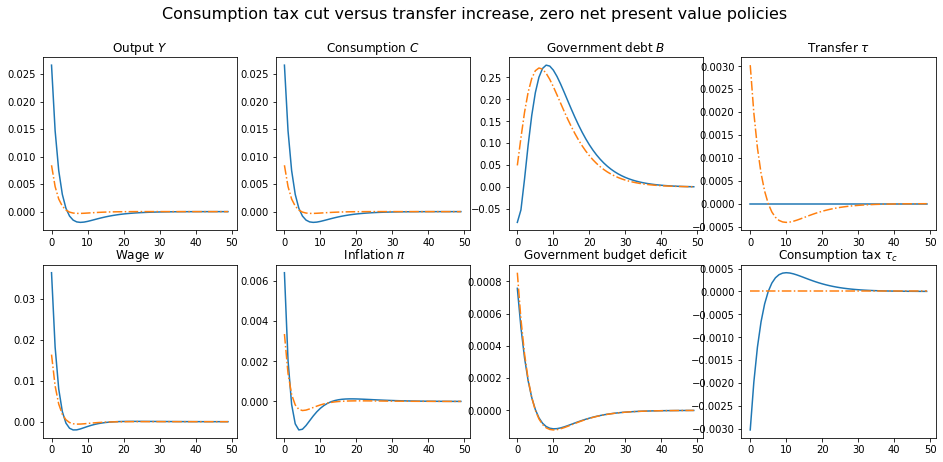

--------------------------------------------------
DIFFERENCE τc vs τ   IMPACT RATIO   CUMULATIVE SUM
--------------------------------------------------
Shocks                  1.000                0.000
Output                  3.158                0.018
Consumption             3.158                0.018
Inflation               1.909               -0.001
Wage                    2.221                0.031
Deficit                 0.886                0.003


In [101]:
# Zero net present value shock
shock = np.zeros(T)
discount = (1 / (1 + ss['r']))
#discount = 1
#A, B, C, D, E = 1, 0.5, 0.19499, 5, 3
A, B, C, D, E = 1, 0.5, 0.19499, 5, 3
for x in range(T):
    shock[x] = discount ** x * (A - B * (x - E)) * np.exp(-C * (x - E) - D) 

# Integral
#intshock = 1 / (C ** 2) * (np.exp(C * (E - T) - D) * (np.exp(50 * C) * (A * C + B * (C * E - 1)) 
#                                                       - A * C + B * (- C) * (E - 50) + B))
intshock = (1 / (C-np.log(discount))** 2 * np.exp(C*E-D) * 
            (discount**T * np.exp(-60*C) * (np.log(discount) * (A+B*(E-T)) - A*C+B*(-C)*(E-T)+B) 
             - np.log(discount) * (A+B*E) + A*C + B*C*E - B))

dY = [G['Y']['tauc'] @ (-shock), G['Y']['Transfer'] @ shock]
dC = [G['C']['tauc'] @ (-shock), G['C']['Transfer'] @ shock]
dN = [G['N']['tauc'] @ (-shock), G['N']['Transfer'] @ shock]
dB = [G['A']['tauc'] @ (-shock), G['A']['Transfer'] @ shock]
dw = [G['w']['tauc'] @ (-shock), G['w']['Transfer'] @ shock]
dP = [G['pi']['tauc'] @ (-shock), G['pi']['Transfer'] @ shock]
dp = [G['cpi']['tauc'] @ (-shock), G['cpi']['Transfer'] @ shock]
dr = [G['r']['tauc'] @ (-shock), G['r']['Transfer'] @ shock]
dD = [G['Deficit']['tauc'] @ (-shock), G['Deficit']['Transfer'] @ shock]
dd = [G['Div']['tauc'] @ (-shock), G['Div']['Transfer'] @ shock]
dT = [np.zeros(T), G['Trans']['Transfer'] @ shock]
di = [np.zeros(T), np.zeros(T)]

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
fig.suptitle('Consumption tax cut versus transfer increase, zero net present value policies', size=16)

ax[0, 0].set_title(r'Output $Y$')
l1, = ax[0, 0].plot(dY[0][:50] * ss['Y'])
l2, = ax[0, 0].plot(dY[1][:50] * ss['Y'],'-.')

ax[0, 1].set_title(r'Consumption $C$')
ax[0, 1].plot(dC[0][:50] * ss['C'])
ax[0, 1].plot(dC[1][:50] * ss['C'],'-.')

ax[0, 2].set_title(r'Government debt $B$')
ax[0, 2].plot(dB[0][:50] * ss['A'])
ax[0, 2].plot(dB[1][:50] * ss['A'],'-.')

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dT[1][:50] * ss['Trans'],'-.')

ax[1, 0].set_title(r'Wage $w$')
ax[1, 0].plot(dw[0][:50] * ss['w'])
ax[1, 0].plot(dw[1][:50] * ss['w'],'-.')

ax[1, 1].set_title(r' Inflation $\pi$')
ax[1, 1].plot(dP[0][:50])
ax[1, 1].plot(dP[1][:50],'-.')

ax[1, 2].set_title(r'Government budget deficit')
ax[1, 2].plot(-dD[0][:50] * ss['Deficit'])
ax[1, 2].plot(-dD[1][:50] * ss['Deficit'],'-.')

ax[1, 3].set_title(r'Consumption tax $\tau_c$')
ax[1, 3].plot(- dT[1][:50] * ss['tauc'])
ax[1, 3].plot(np.zeros(50),'-.')
plt.show()

#print(intshock)
##print(np.sum(shock))
#plt.plot(-shock[0:50])
#plt.plot([0, 50], [0, 0], 'k-', lw=.5)
#plt.show()

# Discounted cumulative sum
cumtau, cumY, cumC, cumP, cumW, cumD = np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T)
discount = (1 / (1 + ss['r']))
#discount = ss['beta']
for i in range(T):
    cumtau[i] = discount ** i * (-dT[1][i] + dT[1][i])
    cumY[i] = discount ** i * (dY[0][i] - dY[1][i])
    cumC[i] = discount ** i * (dC[0][i] - dC[1][i])
    cumP[i] = discount ** i * (dP[0][i] - dP[1][i])
    cumW[i] = discount ** i * (dw[0][i] - dw[1][i])
    cumD[i] = discount ** i * (dD[0][i] - dD[1][i])

# Show difference between consumption tax and transfers
dif = [['DIFFERENCE \u03C4c vs \u03C4','IMPACT RATIO','CUMULATIVE SUM'],
      ['Shocks',np.ndarray.item((dT[1][:1] * ss['tauc']) / (dT[1][:1] * ss['Trans'])),np.sum(cumtau)],
      ['Output',np.ndarray.item(dY[0][:1] / dY[1][:1]), np.sum(cumY) * ss['Y']],
      ['Consumption',np.ndarray.item(dC[0][:1] / dC[1][:1]), np.sum(cumC)],
      ['Inflation',np.ndarray.item(dP[0][:1] / dP[1][:1]), np.sum(cumP)],
      ['Wage',np.ndarray.item(dw[0][:1] / dw[1][:1]), np.sum(cumW)],
      ['Deficit',np.ndarray.item(dD[0][:1] / dD[1][:1]), np.sum(cumD)]]
dash = '-' * 50
for i in range(len(dif)):
    if i == 0:
        print(dash)
        print('{:<20s} {:^12s}  {:>15s}'.format(dif[i][0],dif[i][1],dif[i][2]))
        print(dash)
    else:
        print('{:<20s} {:^12.3f}  {:>15.3f}'.format(dif[i][0],dif[i][1],dif[i][2]))
    

In [84]:
np.shape(dY[0][:50])

(50,)

In [75]:
dY

[array([-2.66181671e-02, -1.46934300e-02, -7.46101808e-03, -3.13808449e-03,
        -6.14872350e-04,  7.99941603e-04,  1.53767642e-03,  1.86597641e-03,
         1.95224756e-03,  1.90018444e-03,  1.77364018e-03,  1.61181919e-03,
         1.43812933e-03,  1.26634347e-03,  1.10402231e-03,  9.54960360e-04,
         8.20736001e-04,  7.01509578e-04,  5.96711093e-04,  5.05352743e-04,
         4.26240771e-04,  3.58118131e-04,  2.99742342e-04,  2.49924460e-04,
         2.07572380e-04,  1.71708614e-04,  1.41452791e-04,  1.15999793e-04,
         9.46507768e-05,  7.68015968e-05,  6.19279192e-05,  4.95824875e-05,
         3.93912357e-05,  3.10068314e-05,  2.41255773e-05,  1.85002840e-05,
         1.39232735e-05,  1.02204304e-05,  7.24603926e-06,  4.87522908e-06,
         3.00109030e-06,  1.53504092e-06,  4.10427367e-07, -4.40325156e-07,
        -1.07816580e-06, -1.54774720e-06, -1.88299735e-06, -2.11026699e-06,
        -2.25012349e-06, -2.32064311e-06, -2.33596378e-06, -2.30572010e-06,
        -2.2

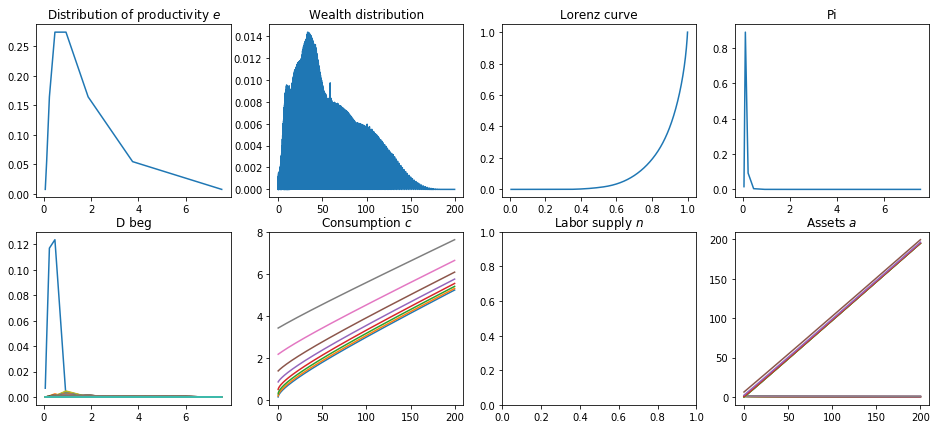

In [55]:
# More plots
fig, ax = plt.subplots(2, 4)

ax[0, 0].set_title(r'Distribution of productivity $e$')
ax[0, 0].plot(ss.internals['household']['e_grid'],ss.internals['household']['pi_e']) # distribution of skills (n_E types)
#ax[0, 0].plot(ss.internals['household']['pi_e']) # distribution of skills (n_E types)

ax[0, 1].set_title(r'Wealth distribution')
ax[0, 1].plot(asset[asset_pos], asset_mass)

ax[0, 2].set_title(r'Lorenz curve')
ax[0, 2].plot(np.cumsum(mass[asset_pos]), np.cumsum(asset_mass / total_wealth)) 
#ax[0, 2].axline((0, 0), slope=1.)

ax[0, 3].set_title(r'Pi')
ax[0, 3].plot(ss.internals['household']['e_grid'],ss.internals['household']['Pi'][1])

ax[1, 0].set_title(r'D beg')
ax[1, 0].plot(ss.internals['household']['e_grid'],ss.internals['household']['Dbeg'])

ax[1, 1].set_title(r'Consumption $c$')
ax[1, 1].plot(ss.internals['household']['a_grid'], ss.internals['household']['c'].T)

ax[1, 2].set_title(r'Labor supply $n$')
ax[1, 3].plot(ss.internals['household']['a_grid'], ss.internals['household']['n'].T)

ax[1, 3].set_title(r'Assets $a$')
ax[1, 3].plot(ss.internals['household']['a_grid'], ss.internals['household']['a'].T)
plt.show()


In [35]:
150/6

25.0

In [34]:
asset_mass[3980:4000]

array([ 1.59785889e-03,  4.62698705e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.16373111e-13,  6.08014381e-16,  2.28228389e-05,
        1.43630270e-03,  1.99992106e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.28200291e-03,  0.00000000e+00, -1.74987742e-02,  2.42702542e-02])